CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [110]:
!pip install captum

You should consider upgrading via the '/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/bin/python -m pip install --upgrade pip' command.


In [111]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [112]:
# TODO: Enter your code here

df = pd.read_csv('hdb_price_prediction.csv')

train_data = df[df['year'] <= 2019]
validation_data = df[df['year'] == 2020]
test_data = df[df['year'] == 2021]

# Drop all categorical features
target = ['resale_price']
continuous_cols = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
categorical_cols = ['month', 'town', 'flat_model_type', 'storey_range']

train_data = train_data[continuous_cols + target]
validation_data = validation_data[continuous_cols + target]
test_data = test_data[continuous_cols + target]

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [113]:
batch_size = 64
num_epochs = 100
learning_rate = 0.001
size_hidden1 = 5
size_hidden2 = 5
size_hidden3 = 5
no_labels = 1

In [114]:
# TODO: Enter your code here

from torch.utils.data import DataLoader, TensorDataset

# Convert dataframes to PyTorch tensors
X_train = torch.tensor(train_data[continuous_cols].values).float()
y_train = torch.tensor(train_data[target].values).view(-1, 1).float()

X_val = torch.tensor(validation_data[continuous_cols].values).float()
y_val = torch.tensor(validation_data[target].values).view(-1, 1).float()

X_test = torch.tensor(test_data[continuous_cols].values).float()
y_test = torch.tensor(test_data[target].values).view(-1, 1).float()

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [115]:
class HDBResaleModel(nn.Module):
    def __init__(self, no_features, no_hidden1, no_hidden2, no_hidden3, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden1, no_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden2, no_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden3, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [116]:
model = HDBResaleModel(X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()

In [117]:
def train(model_inp, num_epochs, optimizer, loss_fn, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = loss_fn(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 216568218206208.000
Epoch [21]/[100] running accumulative loss across all batches: 216582018138112.000
Epoch [41]/[100] running accumulative loss across all batches: 216576146948096.000
Epoch [61]/[100] running accumulative loss across all batches: 216566586785792.000
Epoch [81]/[100] running accumulative loss across all batches: 216567483006976.000


In [118]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation

sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)
gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

# sal_attr_test = sal.attribute(X_test)
# ixg_attr_test = ixg.attribute(X_test)
# ig_attr_test = ig.attribute(X_test, n_steps=50)
# gs_attr_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)

/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


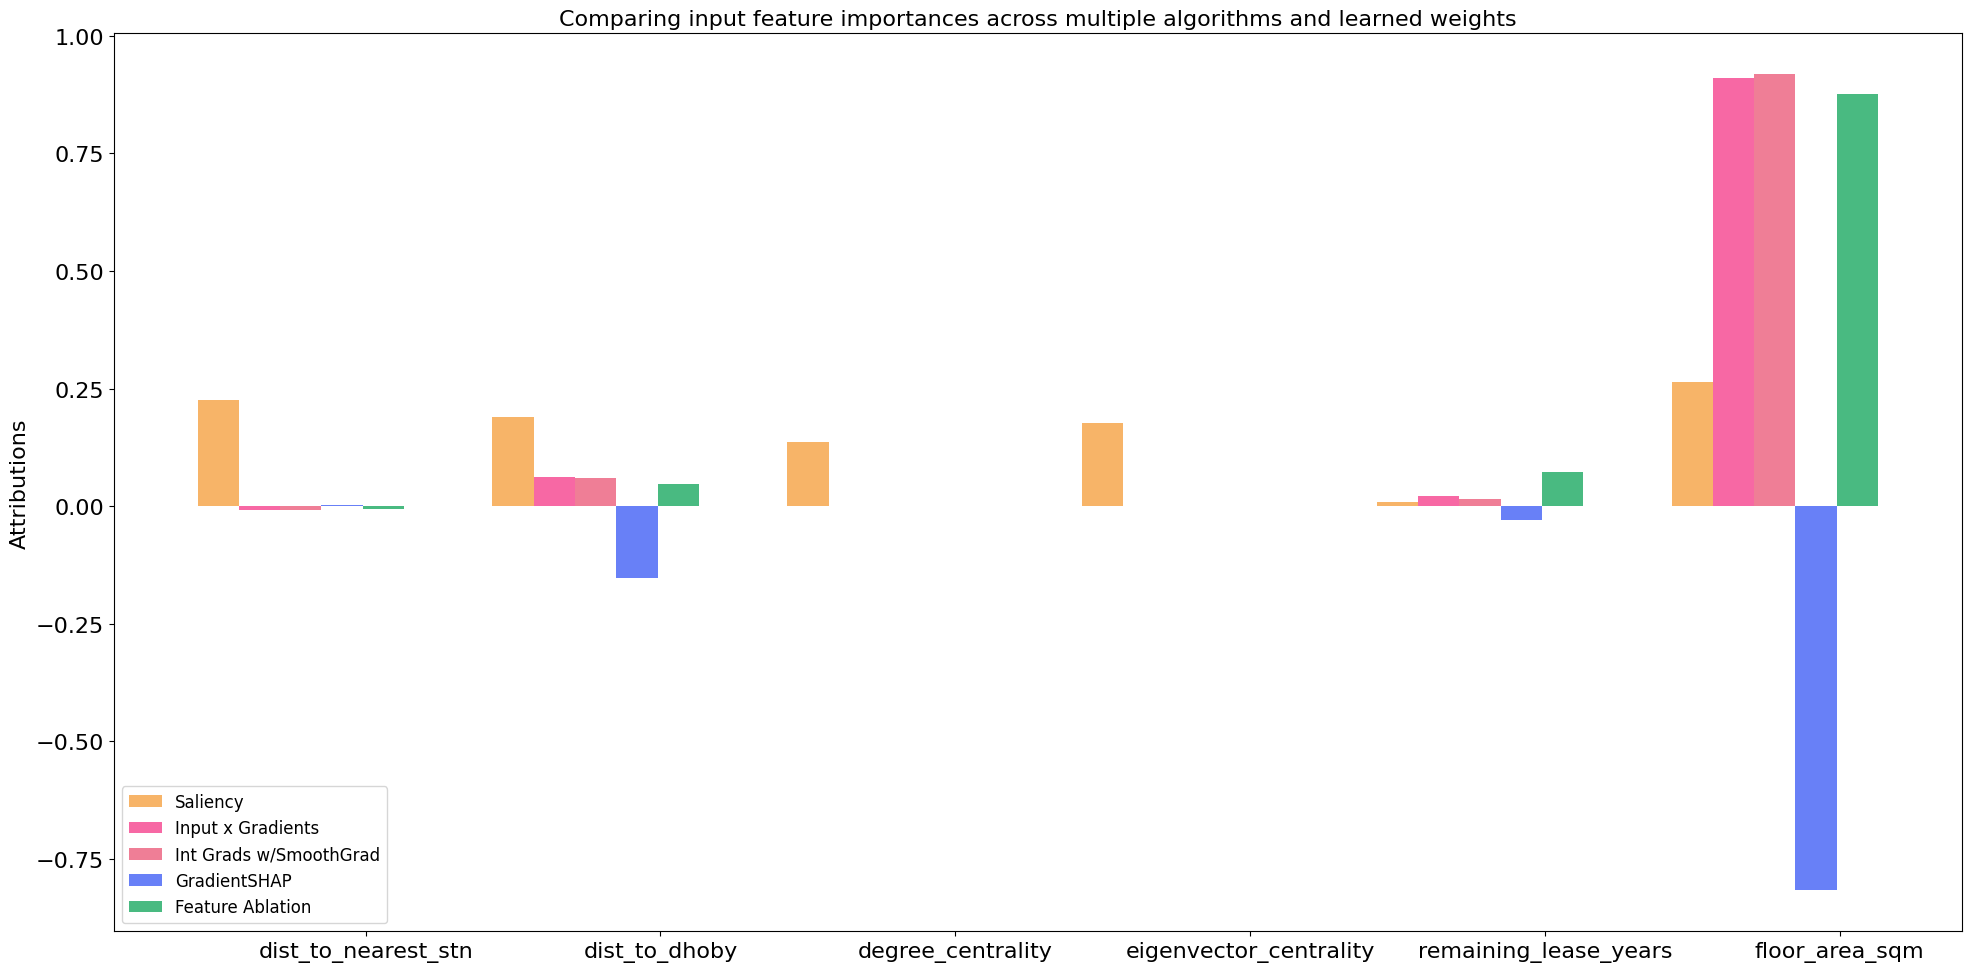

In [119]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Int Grads w/SmoothGrad', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = torch.tensor(scaled_X_train).float() # fixed typo

scaled_X_val = scaler.transform(X_val)
scaled_X_val = torch.tensor(scaled_X_val).float()

scaled_X_test = scaler.transform(X_test)
scaled_X_test = torch.tensor(scaled_X_test).float()

# Create data loaders
train_dataset = TensorDataset(scaled_X_train, y_train)
val_dataset = TensorDataset(scaled_X_val, y_val)
test_dataset = TensorDataset(scaled_X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HDBResaleModel(scaled_X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 216412119416832.000
Epoch [21]/[100] running accumulative loss across all batches: 3920849661184.000
Epoch [41]/[100] running accumulative loss across all batches: 3656344747520.000
Epoch [61]/[100] running accumulative loss across all batches: 3512333678464.000
Epoch [81]/[100] running accumulative loss across all batches: 3396215803648.000


In [121]:
sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test[:1000])
ixg_attr_test = ixg.attribute(X_test[:1000])
ig_attr_test = ig.attribute(X_test[:1000], n_steps=50)
gs_attr_test = gs.attribute(X_test[:1000], X_train)
fa_attr_test = fa.attribute(X_test[:1000])

/Users/advait/Desktop/gitpositories/SC4001-Assignment/env/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


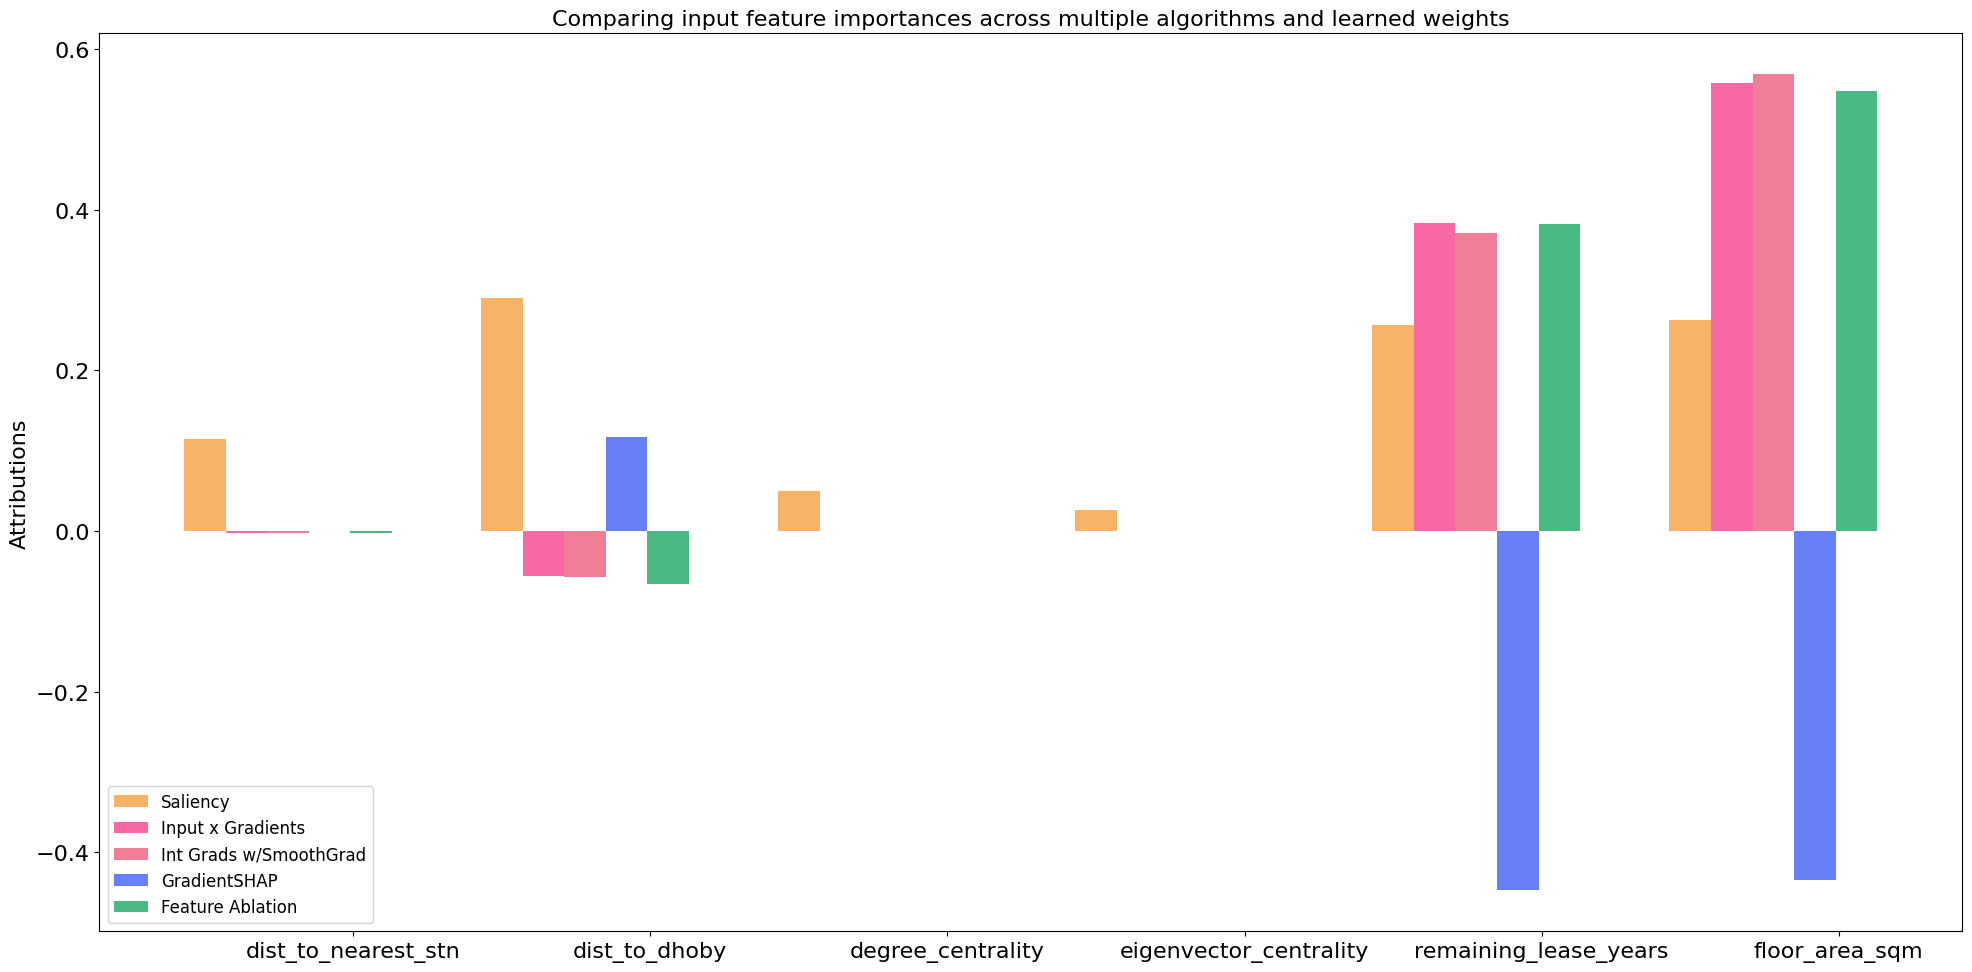

In [122]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Int Grads w/SmoothGrad', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


\# TODO: \<Enter your answer here\>

> Why did Input x Gradients give the same attribution scores as IG?


\# TODO: \<Enter your answer here\>